## Setup

## Extração de Dados

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

## Análise dos Dados

In [2]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Muita informação ausente quanto a _Cabin_ e algumas quanto à _Age_.

In [4]:
print('N/A train')
print(train.isnull().sum())

N/A train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Supondo que "mulheres e crianças primeiro!" foi mesmo uma abordagem tomada, podemos avaliar estes detalhes:

In [5]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.FacetGrid(train, col='Survived').map(plt.hist, 'Sex', bins=2)
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


,Age,Survived
0,0.42,1.0
9,5.00,1.0
79,63.00,1.0
68,53.00,1.0
1,0.67,1.0
...,...,...
37,28.50,0.0
49,36.50,0.0
46,34.50,0.0
26,20.50,0.0


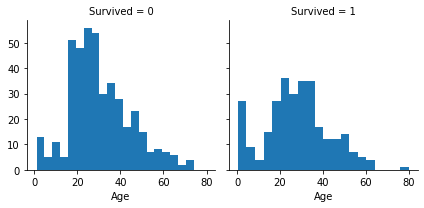

In [6]:
sb.FacetGrid(train, col='Survived').map(plt.hist, 'Age', bins=20)
train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Visualmente, parece que a maioria das crianças até 5 anos sobreviveu, a maioria dos adultos de 20 a 40 morreu. Revendo esses dados:

,Age,Survived
0,0,0.704545
2,2,0.397403
1,1,0.377778
3,3,0.327217


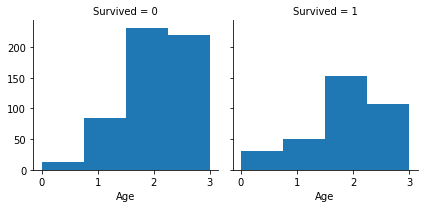

In [7]:
df = train[['Age', 'Survived']].copy()
df['Age'] = df.apply(lambda row: 0 if row.Age <= 5 else 1 if row.Age <= 20 else 2 if row.Age <= 40 else 3, axis=1)
sb.FacetGrid(df, col='Survived').map(plt.hist, 'Age', bins=4)
df[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)


Vamos incluir essas novas características nos dados:

In [8]:
train['eh_mulher'] = train.apply(lambda row: 1 if row.Sex =='female' else 0, axis=1)
train['eh_crianca'] = train.apply(lambda row: 1 if row.Age <= 5 else 0, axis=1)

E então pode-se fazer analisar as correlações entre os valores numéricos.

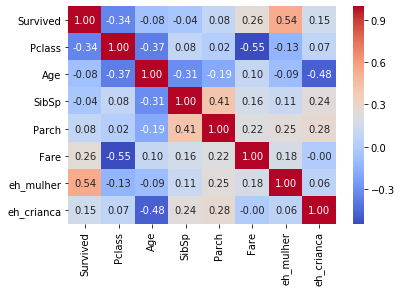

In [9]:
numeric_data = train.drop('PassengerId', axis=1).select_dtypes(include=np.number)
sb.heatmap(numeric_data.corr(), annot=True, fmt='.2f',cmap ='coolwarm')

Aparentemente, "ser mulher" tem correlação direta com a sobrevivência, e o cavalheirismo teria influência... Ser "criança", nem tanto, mas isso talvez possa ser devido à grande quantidade de dados ausentes para idade. 

O valor da passagem parece ser relevante também.

## Preprocessing

In [10]:
X_train = train.select_dtypes(include=np.number).drop(['PassengerId', 'Survived'], axis=1)
y_train = train['Survived']

X_test = test.select_dtypes(include=np.number).drop('PassengerId', axis=1)
X_test['eh_mulher'] = test.apply(lambda row: 1 if row.Sex =='female' else 0, axis=1)
X_test['eh_crianca'] = test.apply(lambda row: 1 if row.Age <= 5 else 0, axis=1)

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

## Fit / Predict

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

model_instances = [DecisionTreeClassifier(), GaussianNB(), LogisticRegression(solver='lbfgs', max_iter=1000), RandomForestClassifier(n_estimators=100)]

In [12]:
def simple_score(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return 100 * model.score(X_train,y_train)

In [13]:
from sklearn.model_selection import cross_val_score

def cv_score(model, cv=10):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return 100 * cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

## Evaluate

In [14]:
results = {'Model': [type(model).__name__ for model in model_instances],
           'Score': [simple_score(model) for model in model_instances],
           'CV_Score': [cv_score(model, 10) for model in model_instances]}

models_eval = pd.DataFrame(results)

In [15]:
models_eval.sort_values(by='Score',ascending=False)

,Model,Score,CV_Score
0,DecisionTreeClassifier,98.204265,76.998752
3,RandomForestClassifier,98.204265,80.933833
2,LogisticRegression,81.705948,80.806492
1,GaussianNB,80.134680,78.234707


In [16]:
models_eval.sort_values(by='CV_Score',ascending=False)

,Model,Score,CV_Score
3,RandomForestClassifier,98.204265,80.933833
2,LogisticRegression,81.705948,80.806492
1,GaussianNB,80.134680,78.234707
0,DecisionTreeClassifier,98.204265,76.998752


## Submit

In [17]:
best_model_name = models_eval['Model'][models_eval['CV_Score'].idxmax()]

for model in model_instances:
    if type(model).__name__ == best_model_name:
        y_pred = model.predict(X_test)
        break

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})
submission.to_csv('submission.csv',index=False)